In [2]:
import re
import speech_recognition as sr
from pydub import AudioSegment


def split_text(transcript):
    return transcript.split()

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()

    # WAV 파일로 변환한 파일을 사용하여 음성을 텍스트로 변환
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)

    try:
        transcript = recognizer.recognize_google(audio_data, language='ko-KR')
        return transcript
    except sr.UnknownValueError:
        print("음성을 인식할 수 없습니다.")
        return None
    except sr.RequestError as e:
        print(f"Google API 요청에 실패했습니다.: {e}")
        return None

# 음성 파일 경로
audio_path = output

# 음성을 텍스트로 변환
transcript = transcribe_audio(audio_path)
print(transcript)

# 단어 단위로 분리
if transcript:
    words = split_text(transcript)
    print(words)

안녕하세요 교수님 식사는 하셨습니까
['안녕하세요', '교수님', '식사는', '하셨습니까']


In [3]:
import scipy.io.wavfile as wf
import numpy as np
import os
# 음성녹음파일
def _read_wav(wave_file):
    rate, data = wf.read(wave_file)
    channels = len(data.shape)

    # 스테레오인 경우 모노로 변환
    if channels == 2:
        data = np.mean(data, axis=1, dtype=data.dtype)
    
    return data, rate
    
# WAV 파일 읽기
y1, sr1 = _read_wav(output)

clova_dict = dict()
interval = len(y1)/sr1/len(words)
point = 3
bias = 0.3
for i, ch in enumerate(words):
    if i==0:
        clova_dict[ch] = [round(i*interval, point), round((i+1)*interval+bias, point)]
    elif i == len(words):
        clova_dict[ch] = [round(i*interval-bias, point), round((i+1)*interval, point)]
    else:
        clova_dict[ch] = [round(i*interval-bias, point), round((i+1)*interval+bias, point)]
        
number = round((len(y1)/sr1)/interval)
    
print(clova_dict)
print(number)

{'안녕하세요': [0.0, 1.052], '교수님': [0.452, 1.803], '식사는': [1.203, 2.555], '하셨습니까': [1.955, 3.306]}
4


In [4]:
from pydub import AudioSegment
from datetime import datetime

# 음성 파일 경로
audio_path = output

audio = AudioSegment.from_wav(audio_path)

output_path = '/home/piai/Clova'

for i, ch in enumerate(clova_dict):
    # 각 단어 별 시작시간, 끝시간 입력
    start_frame = clova_dict[ch][0]
    end_frame = clova_dict[ch][1]

    # 구간 데이터 추출
    cut_audio = audio[start_frame*1000:end_frame*1000]

    # 현재 시간으로 파일명 생성
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_filename = f"{output_path}/TTSsplit_{ch}_{timestamp}.wav"

    # 파일 생성
    cut_audio.export(output_filename, format='wav')
    print(f"saved as {output_filename}")


saved as /home/piai/Clova/TTSsplit_안녕하세요_20231218-040114.wav
saved as /home/piai/Clova/TTSsplit_교수님_20231218-040114.wav
saved as /home/piai/Clova/TTSsplit_식사는_20231218-040114.wav
saved as /home/piai/Clova/TTSsplit_하셨습니까_20231218-040114.wav


Merged audio saved as /home/piai/Clova/removegap_20231219-051816.wav


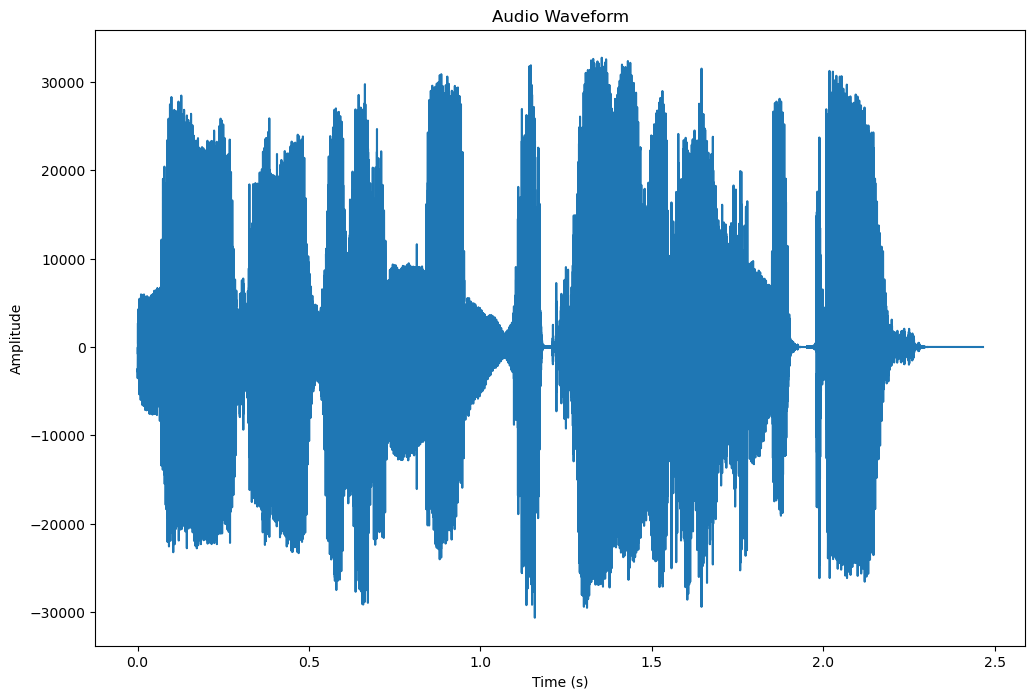

In [98]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
from datetime import datetime
import os

# VAD를 사용하여 음성 파일 분류 및 나누기 함수
def vad_merge(input_file, output_path, silence_thresh=-40, min_silence_len=500, keep_silence=False):
    # 파일 확장자 확인 및 변환
    file_name, file_extension = os.path.splitext(input_file)
    if file_extension.lower() == '.mp3':
        # MP3 파일을 로드하고 WAV 형식으로 변환
        audio = AudioSegment.from_mp3(input_file)
        wav_path = f'{file_name}.wav'
        audio.export(wav_path, format='wav')
        input_file = wav_path
    else:
        # WAV 파일 불러오기
        audio = AudioSegment.from_wav(input_file)

    # 침묵이 아닌 구간 검출
    nonsilent_ranges = detect_nonsilent(audio, silence_thresh=silence_thresh, min_silence_len=min_silence_len)

    # 시작 부분의 공백 제거
    if nonsilent_ranges:
        start, end = nonsilent_ranges[0]
        merged_audio = audio[start:end]
    else:
        print("No nonsilent ranges found, unable to merge.")
        return

    # 나머지 nonsilent 구간을 합치기
    for start, end in nonsilent_ranges[1:]:
        merged_audio += audio[start:end]

    # 고유한 파일 이름 생성
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_removegap = f"{output_path}/removegap_{timestamp}.wav"

    # 저장
    merged_audio.export(output_removegap, format="wav")
    print(f"Merged audio saved as {output_removegap}")

    # 음성 데이터를 플로팅
    plot_waveform(merged_audio)
    
    return output_removegap

def plot_waveform(audio):
    # 음성 데이터 추출
    data = np.array(audio.get_array_of_samples())
    time = np.linspace(0, len(data) / audio.frame_rate, num=len(data))

    # 그래프 플로팅
    plt.figure(figsize=(12, 8))
    plt.plot(time, data)
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# 입력 음성 파일 경로 및 출력 경로 지정
input_file = '/home/piai/다운로드/data/사투리3.mp3'
output_path = '/home/piai/Clova'

# VAD를 사용하여 음성 파일 분류 및 합치기
removegap_result = vad_merge(input_file, output_path)

## => input_file = 음성 녹음 파일/ output_path = 공백제거한 파일 경로
결과 = removegap_result

# 녹음 음성 파일 노이즈 제거

In [68]:
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from datetime import datetime
import soundfile as sf

# 노이즈 제거 함수
def remove_noise(input_file, low_cut=300, high_cut=3000):
    y, sr = librosa.load(input_file, sr=None)
    nyquist = sr / 2
    b, a = signal.butter(5, [low_cut/nyquist, high_cut/nyquist], btype='band')
    filtered_signal = signal.lfilter(b, a, y)
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_denoised = f'/home/piai/denoised_{timestamp}.wav'
    print(f"saved as {output_denoised}")
    sf.write(output_denoised, filtered_signal, sr)
    return output_denoised

# def plot_waveform2(signal, sample_rate):
#     time = np.linspace(0, len(signal) / sample_rate, num=len(signal))
#     plt.figure(figsize=(12, 8))
#     plt.plot(time, signal)
#     plt.title("Audio Waveform")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Amplitude")
#     plt.show()
    
input_file = removegap_result  # 이전 단계에서 생성된 파일
denoised_result = remove_noise(input_file)

saved as /home/piai/denoised_20231219-042926.wav


In [15]:
import re
import speech_recognition as sr
from pydub import AudioSegment


def split_text(transcript):
    return transcript.split()

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()

    # WAV 파일로 변환한 파일을 사용하여 음성을 텍스트로 변환
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)

    try:
        transcript = recognizer.recognize_google(audio_data, language='ko-KR')
        return transcript
    except sr.UnknownValueError:
        print("음성을 인식할 수 없습니다.")
        return None
    except sr.RequestError as e:
        print(f"Google API 요청에 실패했습니다.: {e}")
        return None

# 음성 파일 경로
audio_path = removegap_result

# 음성을 텍스트로 변환
transcript = transcribe_audio(audio_path)
print(transcript)

# 단어 단위로 분리
if transcript:
    words = split_text(transcript)
    print(words)

안녕하세요 교수님 식사는 하셨습니까
['안녕하세요', '교수님', '식사는', '하셨습니까']


In [136]:
#한 어절씩
import re
import speech_recognition as sr
from pydub import AudioSegment

def split_syllables(transcript):
    return [char for char in transcript]

def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()

    # WAV 파일로 변환한 파일을 사용하여 음성을 텍스트로 변환
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)

    try:
        transcript = recognizer.recognize_google(audio_data, language='ko-KR')
        return transcript
    except sr.UnknownValueError:
        print("음성을 인식할 수 없습니다.")
        return None
    except sr.RequestError as e:
        print(f"Google API 요청에 실패했습니다.: {e}")
        return None

# 음성 파일 경로
audio_path = '/home/piai/다운로드/data/서울말2.wav'  # 여기에 실제 음성 파일 경로를 입력해야 합니다.

# 음성을 텍스트로 변환
transcript = transcribe_audio(audio_path)
print(transcript)

# 음절 단위로 분리
if transcript:
    words = split_syllables(transcript)
    print(words)


안녕하세요 교수님 식사는 하셨습니까
['안', '녕', '하', '세', '요', ' ', '교', '수', '님', ' ', '식', '사', '는', ' ', '하', '셨', '습', '니', '까']


In [139]:
import scipy.io.wavfile as wf
import numpy as np
import os
# 음성녹음파일
def _read_wav(wave_file):
    rate, data = wf.read(wave_file)
    channels = len(data.shape)

    # 스테레오인 경우 모노로 변환
    if channels == 2:
        data = np.mean(data, axis=1, dtype=data.dtype)
    
    return data, rate
    
# WAV 파일 읽기
y1, sr1 = _read_wav(output)

clova_dict = dict()
interval = len(y1)/sr1/len(words)
point = 3
bias = 0.3
for i, ch in enumerate(words):
    if i==0:
        clova_dict[ch] = [round(i*interval, point), round((i+1)*interval, point)]
    elif i == len(words):
        clova_dict[ch] = [round(i*interval, point), round((i+1)*interval, point)]
    else:
        clova_dict[ch] = [round(i*interval, point), round((i+1)*interval, point)]
        
number = round((len(y1)/sr1)/interval)
    
print(clova_dict)
print(number)

{'안': [0.0, 0.188], '녕': [0.188, 0.376], '하': [2.635, 2.823], '세': [0.565, 0.753], '요': [0.753, 0.941], ' ': [2.447, 2.635], '교': [1.129, 1.317], '수': [1.317, 1.506], '님': [1.506, 1.694], '식': [1.882, 2.07], '사': [2.07, 2.258], '는': [2.258, 2.447], '셨': [2.823, 3.011], '습': [3.011, 3.199], '니': [3.199, 3.388], '까': [3.388, 3.576]}
19


In [140]:
from pydub import AudioSegment
from datetime import datetime

# 음성 파일 경로
audio_path = denoised_result

audio = AudioSegment.from_wav(audio_path)

output_path = '/home/piai/Clova'

for i, ch in enumerate(clova_dict):
    # 각 단어 별 시작시간, 끝시간 입력
    start_frame = clova_dict[ch][0]
    end_frame = clova_dict[ch][1]

    # 구간 데이터 추출
    cut_audio = audio[start_frame*1000:end_frame*1000]

    # 현재 시간으로 파일명 생성
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_filename = f"{output_path}/Usersplit_{ch}_{timestamp}.wav"

    # 파일 생성
    cut_audio.export(output_filename, format='wav')
    print(f"saved as {output_filename}")


saved as /home/piai/Clova/Usersplit_안_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_녕_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_하_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_세_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_요_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_ _20231220-060751.wav
saved as /home/piai/Clova/Usersplit_교_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_수_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_님_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_식_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_사_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_는_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_셨_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_습_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_니_20231220-060751.wav
saved as /home/piai/Clova/Usersplit_까_20231220-060751.wav
